In [21]:
"""
Cambios en la arquitectura de la red neuronal convolucional

    - Valor de funcion de regularizacion L2 a 0.01
    - Se añadio resnet50 como base de la red
    - Se agrego funcion para guardar el mejor modelo
"""

'\nCambios en la arquitectura de la red neuronal convolucional\n\n    - Valor de funcion de regularizacion L2 a 0.01\n    - Se añadio resnet50 como base de la red\n    - Se agrego funcion para guardar el mejor modelo\n'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision.io import read_image
from torchvision import transforms, utils
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
import datetime
from sklearn.preprocessing import StandardScaler
from PIL import Image

In [23]:
seed = 29
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [24]:
# --> Definir si viene desde local o drive

# ruta = '/content/drive/MyDrive/Dataset/Mosaico/'
ruta = '../Dataset/Mosaico/'

ruta_modelo = '../models/'

## Lectura de dataset train

In [25]:
train = pd.read_csv(f'{ruta}train.csv')
train.head()

,bedrooms,bathrooms,area,zipcode,mosaic_image,price
0,2,1.0,1184,91901,82.png,397500
1,2,2.0,1248,93446,471.png,175000
2,5,4.0,4190,85255,18.png,1199000
3,2,2.0,1152,92276,352.png,99900
4,2,1.0,1000,92276,416.png,67000


## Clases y funciones auxiliares

In [2]:
from torch.utils.data import Dataset, DataLoader,ConcatDataset

class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Constructor de la clase que inicializa el dataset personalizado.
        df: DataFrame que contiene los datos (rutas de las imágenes y características numéricas).
        transform: Transformaciones opcionales que se aplicarán a las imágenes (si se proporciona).
        """
        self.df = df  # Guardar el DataFrame que contiene las rutas de imágenes y las características numéricas.
        self.transform = transform  # Almacenar las transformaciones opcionales para las imágenes.

        # Seleccionar las columnas que contienen las características numéricas que deseas estandarizar.
        self.numeric_features = ['bedrooms', 'bathrooms', 'area', 'zipcode']

        # Inicializar el estandarizador de sklearn (StandardScaler) y ajustarlo a las características numéricas.
        self.scaler = StandardScaler()

        # Aplicar el estandarizador a las columnas de características numéricas y actualizar el DataFrame.
        self.df[self.numeric_features] = self.scaler.fit_transform(self.df[self.numeric_features])

    def __len__(self):
        """Devuelve el número de muestras en el dataset."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Obtiene una muestra del dataset en el índice `idx`.
        """
        # Obtener la ruta de la imagen correspondiente al índice dado.
        img_path = self.df.loc[idx, 'mosaic_image']

        # Leer la imagen utilizando PIL.Image.open para que las transformaciones funcionen correctamente.
        mosaic_image = Image.open(f"{ruta}Imagenes/{img_path}").convert("RGB")

        # Obtener los valores de las características numéricas para la muestra actual.
        bathrooms = torch.tensor(self.df.loc[idx, 'bathrooms'], dtype=torch.float32)
        bedrooms = torch.tensor(self.df.loc[idx, 'bedrooms'], dtype=torch.float32)
        area = torch.tensor(self.df.loc[idx, 'area'], dtype=torch.float32)
        zipcode = torch.tensor(self.df.loc[idx, 'zipcode'], dtype=torch.float32)
        price = torch.tensor(self.df.loc[idx, 'price'], dtype=torch.float32)  # Precio como el valor objetivo.

        # Aplicar las transformaciones a la imagen si se proporcionaron en el constructor.
        if self.transform:
            mosaic_image = self.transform(mosaic_image)

        # Concatenar las características numéricas (bathrooms, bedrooms, area, zipcode) en un único tensor.
        numeric_features = torch.hstack((bathrooms, bedrooms, area, zipcode))

        # Devolver la imagen procesada, las características numéricas estandarizadas y el precio objetivo.
        return mosaic_image, numeric_features, price

In [27]:
import matplotlib.pyplot as plt
import torch

# Función para deshacer la normalización (inverso de transforms.Normalize)
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1) # Ajustar la media a la forma del tensor
    std = torch.tensor(std).view(3, 1, 1)   # Ajustar la desviación estándar a la forma del tensor
    return tensor * std + mean

# Función para mostrar una imagen
def show_image(image_tensor, title=None, apply_desnormalize=False):
    # Deshacer la normalización con los valores de ImageNet
    if apply_desnormalize:
        image_tensor = denormalize(image_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    # Asegurarse de que los valores de los píxeles estén entre 0 y 1 para matplotlib
    image_tensor = torch.clamp(image_tensor, 0, 1)

    # Convertir el tensor a numpy
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Cambia las dimensiones de (C, H, W) a (H, W, C)

    # Mostrar la imagen
    plt.imshow(image)  # Mostrar sin conversión a uint8 porque los valores están en rango [0, 1]
    if title:
        plt.title(title)
    plt.axis('off')  # Quitar los ejes
    plt.show()


In [3]:
from torchvision import models
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Cargar el modelo preentrenado ResNet50
        self.image_features_ = models.resnet50(pretrained=True)

        # Eliminar la última capa de clasificación (fully connected) de ResNet50
        self.image_features_ = nn.Sequential(*list(self.image_features_.children())[:-1])

        # Procesamiento de las características numéricas (4 características)
        self.numeric_features_ = nn.Sequential(
            nn.Linear(4, 64),   # Aquí usas 4 datos numéricos
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, 64*3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3, 64*3*3),
            nn.ReLU(inplace=True),
        )

        # Capa final que combina las características visuales y numéricas
        self.combined_features_ = nn.Sequential(
            nn.Linear(2048 + 64*3*3, 64*3*3*2*2),  # 2048 provienen de ResNet50 + numéricas
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3*3*2*2, 64*3*3*2),
            nn.ReLU(inplace=True),
            nn.Linear(64*3*3*2, 64),
            nn.Linear(64, 1),  # Predicción final
        )

    def forward(self, x, y):
        # Pasar las imágenes por ResNet50 para obtener las características visuales
        x = self.image_features_(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)

        # Pasar las características numéricas por la red densa
        y = self.numeric_features_(y)

        # Combinar características visuales y numéricas
        z = torch.cat((x, y), dim=1)
        # print(z.shape)

        # Pasar las características combinadas por las capas finales
        z = self.combined_features_(z)

        return z.squeeze(1)

In [29]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [30]:
def test_loop(dataloader, model, loss_fn, device):
    """
    Función para realizar un bucle de prueba en el conjunto de datos de prueba.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    total_error = 0

    with torch.no_grad():
        for batch_idx, (imgs, numeric_features, price) in enumerate(dataloader):
            # Mandar datos al dispositivo
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            # Predecir
            pred = model(imgs, numeric_features)

            # Calcular pérdida
            batch_loss = loss_fn(pred, price).item()
            test_loss += batch_loss
            total_error += torch.abs(pred - price).sum().item()

            # Imprimir la pérdida de cada batch
            #print(f"Batch {batch_idx+1}/{num_batches}, Batch Loss: {batch_loss:.4f}")

    # Calcular pérdida y error promedio
    test_loss /= num_batches
    avg_error = total_error / size

    #print(f"Test Error: \n Avg loss: {test_loss:.6f}, Avg error: {avg_error:.6f} \n")
    return test_loss

In [31]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device):
    """
    Función para realizar el bucle de entrenamiento.
    """
    train_losses = []
    val_losses = []
    prev_loss = 0

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train()

        for batch_idx, (imgs, numeric_features, price) in enumerate(train_loader):
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            output = model(imgs, numeric_features)

            loss = loss_fn(output, price)

            # L2 Regularization
            l2_lambda = 0.01
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            # Imprimir la pérdida en cada batch
            #print(f"Epoch {epoch}, Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")

        loss_train /= len(train_loader)
        train_losses.append(loss_train)
        #print(f"Epoch {epoch}, Epoch Loss: {loss_train:.4f}")

        model.eval()
        val_loss = test_loop(dataloader=val_loader, model=model, loss_fn=loss_fn, device=device)
        val_losses.append(val_loss)

        # Verificar si la pérdida de validación disminuye
        if epoch == 1:
            prev_loss = val_loss
        else:
            if val_loss < prev_loss:
                # Guardar el modelo si la pérdida de validación disminuye
                torch.save(model, f"{ruta_modelo}model_resnet50_l2_lambda.pth")
                prev_loss = val_loss
                print(f"Modelo guardado en epoch {epoch} con loss {val_loss}".center(100, '='))

        # Imprimir la pérdida promedio en cada epoch
        print(f'[+]Epoch {epoch} - Av.Training loss {loss_train} - Av.Validation loss {val_loss}')
        # print(f'\t[+]Epoch {epoch}, Av.Validation loss {val_loss}')
    #print(prev_loss)
    return train_losses, val_losses

## Ejecución de entrenamiento

In [32]:
# --> Aumentar el tamaño de las muestras de entrenamiento y validación.

# Dataset sin transformaciones adicionales
data1 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con transformación de normalización para ResNet50
data2 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con desplazamiento de canales (RGB a BGR) y normalización para ResNet50
data3 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Lambda(lambda img: img[[2, 1, 0], :, :]),  # Cambiar los canales RGB a BGR (se aplica después de ToTensor)
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con volteo horizontal y normalización para ResNet50
data4 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.8),               # Volteo horizontal con una probabilidad de 80%
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con volteo vertical y normalización para ResNet50
data5 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.RandomVerticalFlip(p=0.8),                 # Volteo vertical con una probabilidad de 80%
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con desenfoque gaussiano y normalización para ResNet50
data6 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))



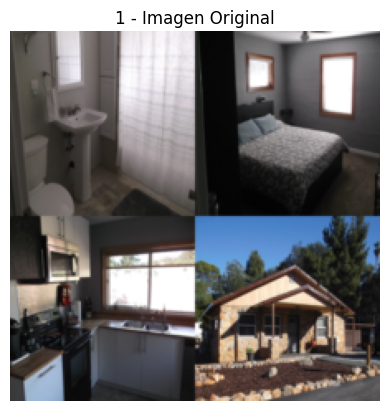

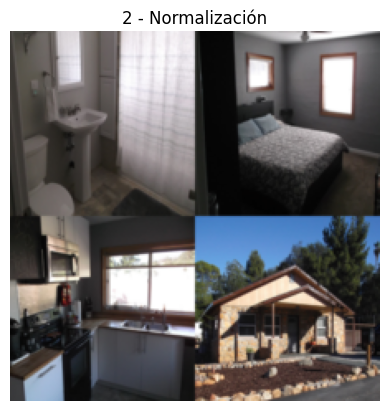

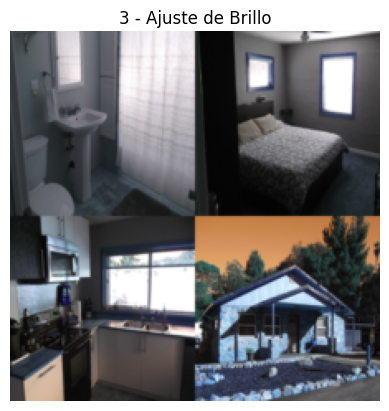

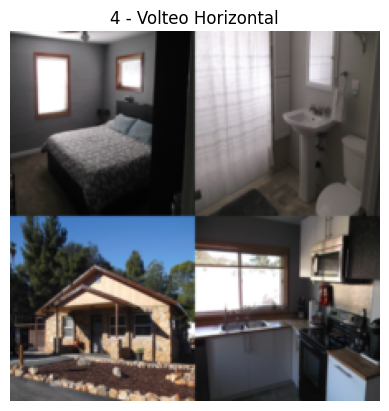

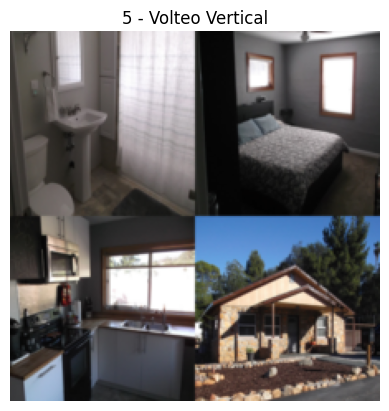

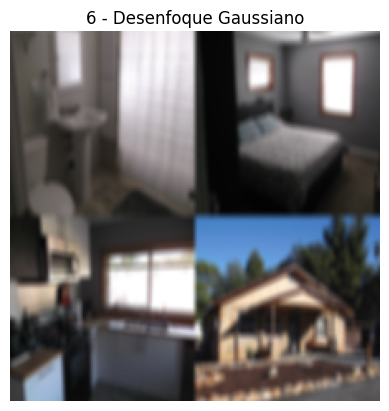

In [33]:
# --> Ver las imágenes de entrenamiento con diferentes transformaciones.

lista_titulos = [
    'Imagen Original', 'Normalización', 'Ajuste de Brillo',
    'Volteo Horizontal', 'Volteo Vertical', 'Desenfoque Gaussiano'
    ]

# Visualizar la primera imagen de cada conjunto de datos
datasets = [data1, data2, data3, data4, data5, data6]

# Iterar
for i, dataset in enumerate(datasets, 1):
    # Obtener la primera muestra del conjunto de datos (imagen, características numéricas, precio)
    image, _, _ = dataset[0]

    show_image(image, title=f"{i} - {lista_titulos[i-1]}", apply_desnormalize=True)

In [34]:
# --> Combinar los conjuntos de datos en un solo conjunto de datos
conjunto_datos = ConcatDataset((data1, data2, data3, data4, data5, data6))

valor_train = int(0.9 * len(conjunto_datos))
valor_val = len(conjunto_datos) - valor_train

print(f"Train: {valor_train} Val: {valor_val}")

Train: 2176 Val: 242


In [35]:
# --> Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_data,val_data=torch.utils.data.random_split(ConcatDataset((data1, data2, data3, data4, data5, data6)), [valor_train, valor_val])

# --> Eliminar las variables que ya no se necesitan
del data1, data2, data3, data4, data5, data6

In [36]:
# --> Definir dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo: {device}")

# --> Definir modelo
model = NeuralNetwork().to(device)              # Modelo de red neuronal mandarlo al dispositivo (GPU)

# --> Definir optimizador y la función de pérdida
# optimizer=optim.Adam(model.parameters(),1e-3)   # Adam optimizer para optimización
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# loss_fn=nn.MSELoss()                          # Mean Squared Error Loss para regresión
loss_fn = RMSELoss()                            # RMSE Loss para regresión

Dispositivo: cuda


c:\Users\Lab.Comp 1\Desktop\Uriel-TT\houses-prediction\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lab.Comp 1\Desktop\Uriel-TT\houses-prediction\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# --> Crear los dataloaders
batch_size_train = 64
batch_size_val = 22

train_dataloader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size_val, shuffle=False)

print(f"Muestras de train: {len(train_data)} - Baches {len(train_dataloader)}")
print(f"Muestras de test: {len(val_data)} - Baches {len(val_dataloader)}")

Muestras de train: 2176 - Baches 34
Muestras de test: 242 - Baches 11


In [38]:
# Entrenamiento
n_epochs = 500
train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    device=device
)

[+]Epoch 1 - Av.Training loss 499447.24724264705 - Av.Validation loss 957517.4829545454
=======================Modelo guardado en epoch 2 con loss 345244.98011363635=======================
[+]Epoch 2 - Av.Training loss 203177.72426470587 - Av.Validation loss 345244.98011363635
[+]Epoch 3 - Av.Training loss 140888.3127297794 - Av.Validation loss 392562.73579545453
=======================Modelo guardado en epoch 4 con loss 177044.58238636365=======================
[+]Epoch 4 - Av.Training loss 125756.07169117648 - Av.Validation loss 177044.58238636365
=======================Modelo guardado en epoch 5 con loss 127513.06107954546=======================
[+]Epoch 5 - Av.Training loss 113305.31640625 - Av.Validation loss 127513.06107954546
=======================Modelo guardado en epoch 6 con loss 117583.91832386363=======================
[+]Epoch 6 - Av.Training loss 98563.43795955883 - Av.Validation loss 117583.91832386363
[+]Epoch 7 - Av.Training loss 100238.90234375 - Av.Validation loss 1

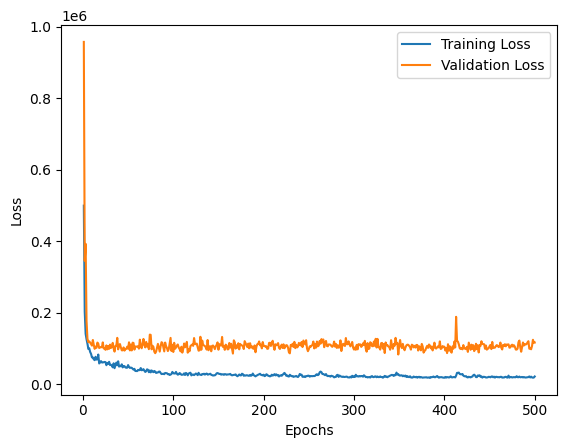

In [48]:
import matplotlib.pyplot as plt

# Graficar las pérdidas
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Probar modelo

In [4]:
import torch

ruta_modelo = '../models/'
# Cargar modelo
# model = torch.load(f"{ruta_modelo}model_resnet50_l2_lambda.pth")

model = torch.load(f"{ruta_modelo}model_resnet50_l2_lambda.pth", map_location=torch.device('cpu'))

In [5]:
import pandas as pd

ruta = '../Dataset/Mosaico/'

# Importar dataset
test = pd.read_csv(f'{ruta}test.csv')
test.head()

,bedrooms,bathrooms,area,zipcode,mosaic_image,price
0,3,2.0,1490,94501,192.png,949000
1,5,5.0,4014,92880,301.png,542000
2,5,3.0,2179,94531,520.png,430000
3,3,2.0,1200,60016,79.png,224900
4,2,2.0,1152,92276,332.png,138500


In [6]:
# Importar transformaciones y standard scaler
from torchvision import transforms
from sklearn.preprocessing import StandardScaler

# Crear dataset
test_data = CustomImageDataset(df=test, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

In [7]:
# Crear dataloader
test_loader = DataLoader(test_data, batch_size=9, shuffle=False)

In [8]:
# Predecir precios de casa

def predict(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    predictions = []
    actuals = []

    with torch.no_grad():  # Deshabilitar el cálculo de gradientes
        for batch_idx, (imgs, numeric_features, target) in enumerate(test_loader):
            # Mover los datos a la GPU si está disponible
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            target = target.to(device)

            # Forward pass: obtener las predicciones
            output = model(imgs, numeric_features)

            # Almacenar las predicciones y los valores reales (en CPU para facilidad)
            predictions.append(output.cpu().numpy())
            actuals.append(target.cpu().numpy())

    # Convertir las listas de predicciones y reales en arrays de NumPy
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return predictions, actuals

In [9]:
from PIL import Image
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Llamar a la función de predicción
predictions, actuals = predict(model, test_loader, device)

# Mostrar algunas predicciones junto con los valores reales
for i in range(10):  # Mostrar los primeros 10 ejemplos
    print(f"Predicción: {predictions[i]}, Valor real: {actuals[i]}")


Predicción: 637616.6875, Valor real: 949000.0
Predicción: 631639.6875, Valor real: 542000.0
Predicción: 528074.1875, Valor real: 430000.0
Predicción: 382760.65625, Valor real: 224900.0
Predicción: 172363.328125, Valor real: 138500.0
Predicción: 656806.0625, Valor real: 699999.0
Predicción: 416185.84375, Valor real: 78000.0
Predicción: 400630.5, Valor real: 245000.0
Predicción: 435056.84375, Valor real: 599900.0
Predicción: 483553.65625, Valor real: 495000.0


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE en el conjunto de prueba: {rmse:.4f}")

# Calcular MAE
mae = mean_absolute_error(actuals, predictions)
print(f"MAE en el conjunto de prueba: {mae:.4f}")

# Calcular R²
r2 = r2_score(actuals, predictions)
print(f"R² en el conjunto de prueba: {r2:.4f}")

# Calcular MAPE
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print(f"MAPE en el conjunto de prueba: {mape:.2f}%")


RMSE en el conjunto de prueba: 231154.6875
MAE en el conjunto de prueba: 176155.4219
R² en el conjunto de prueba: 0.2930
MAPE en el conjunto de prueba: 60.71%


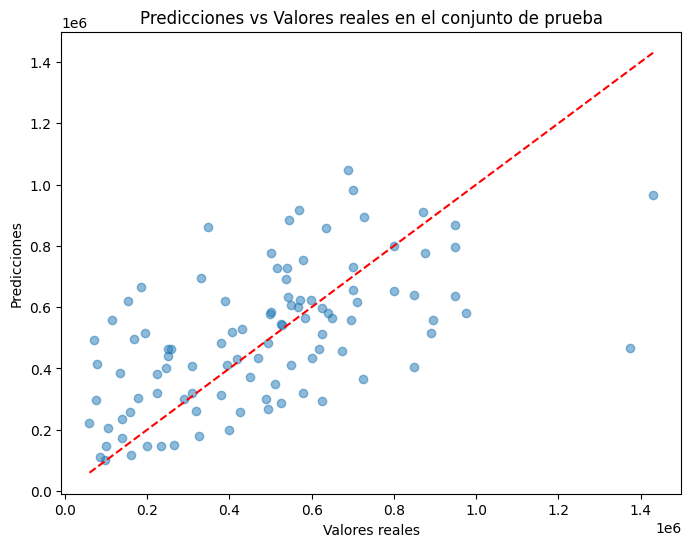

In [24]:
import matplotlib.pyplot as plt

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Línea de igualdad (predicción = realidad)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales en el conjunto de prueba')
plt.show()
